# EDA Project for Metis

## Purpose: Determine where a bicycle shop should be opened in the area near Central Park, NYC.

### Project uses MTA turnstile data (data from NYC subway system).
Import data using SQL and then clean up data using Python. Use Python to create graphs that illustrate trends in the data and help to answer the research question.

In [1]:
from sqlalchemy import create_engine
from scipy import stats
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

# this statement allows the visuals to render within your Jupyter Notebook
%matplotlib inline 

### Get the data.

In [2]:
# Get data through SQLAlchemy and query only the stations of interest.
engine = create_engine("sqlite:///mta_data.db")

df = pd.read_sql("SELECT *\
                FROM mta_data\
                WHERE STATION == 'CATHEDRAL PKWY' OR STATION == '110 ST' OR STATION == '5 AV/59 ST'\
                OR (STATION == '77 ST' AND LINENAME == '6')\
                OR (STATION == '72 ST' AND LINENAME == 'BC') OR (STATION == '72 ST' AND LINENAME == '123')\
                OR (STATION == '96 ST' AND LINENAME == 'BC') OR (STATION == '96 ST' AND LINENAME == '123');",
                 engine)

### Clean the data.

In [3]:
# Fix the dates (and combine time with date). 

df["DATE_TIME"] = pd.to_datetime(df["DATE"] + " " + df["TIME"])

### Add variables

In [4]:
# Create whether the day was a weekend day or weekday.

df["WEEKENDS"] = df["DATE_TIME"].dt.weekday.apply(lambda x: "weekend" if x in [5, 6] else "weekday")

In [5]:
# Create seasons variable to better group months.

def season_creation(date_time):
    if date_time == 4:
        return "spring"
    elif date_time == 7:
        return "summer"
    elif date_time == 9:
        return "fall"
    else:
        return None

df["SEASONS"] = df["DATE_TIME"].dt.month.apply(season_creation)

In [6]:
# Combine the name of the station with the linename to get full name.

df["NAME"] = df["STATION"] + " (" + df["LINENAME"] + ")"

# df["NAME"].unique()

In [7]:
# Add year (used for sorting below).

df["YEAR"] = df["DATE_TIME"].dt.year

### Filter data.

In [8]:
df.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
df.reset_index(inplace=True)

In [9]:
# Sanity Check to verify that "C/A", "UNIT", "SCP", "STATION", "DATE_TIME" is unique
(df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
0,A006,R079,00-00-00,5 AV/59 ST,2019-03-30 02:00:00,1
76367,R169,R168,01-03-01,96 ST,2021-09-22 21:00:00,1
76378,R169,R168,01-03-01,96 ST,2021-09-24 17:00:00,1
76377,R169,R168,01-03-01,96 ST,2021-09-24 13:00:00,1
76376,R169,R168,01-03-01,96 ST,2021-09-24 09:00:00,1


In [10]:
# No duplicates to drop.

# Get rid of the duplicate entry
# df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], 
#                           inplace=True, ascending=False)
# df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [11]:
# New columns with entries/exits shifted.
df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df
                                     .groupby(["DATE", "C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES", "EXITS"]
                                     .apply(lambda grp: grp.shift(1)))

<ipython-input-11-1e5a5bf20aee>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (df


In [12]:
# Create function to fix the issue of previous entries having more counts.
def get_entry_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

def get_exit_counts(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
        print(row["EXITS"], row["PREV_EXITS"])
        return 0
    return counter

In [13]:
# Create new columns that are cleaned entries and exits.

df["ENTRIES_CLEAN"] = df.apply(get_entry_counts, axis=1, max_counter=10000)
df["EXITS_CLEAN"] = df.apply(get_exit_counts, axis=1, max_counter=10000)

130 28020.0
142 509694.0
0 458872.0
69 315829.0
458753 393368.0
162 14098.0
809 260915.0
204 75919.0
124 580826.0
262144 0.0
200 643591.0
218 25967.0
457 13843.0
272 76708.0


In [14]:
# Create final variable of interest = TOTAL counts of entries/exits.

df["TOTAL_COUNTS"] = df["ENTRIES_CLEAN"] + df["EXITS_CLEAN"]

In [15]:
# Set the hours of interest to 8am-8pm(20:00).

df.query("DATE_TIME.dt.hour >= 8 & DATE_TIME.dt.hour <= 20", inplace=True)

In [16]:
# Drop rows with missing data.

df = df.dropna()

In [17]:
# Drop outliers (in this case z-score > 3).

df["z"] = df.groupby(["NAME", "YEAR", "SEASONS", "WEEKENDS"]).TOTAL_COUNTS.transform(lambda x: np.abs(stats.zscore(x, ddof=1)))

df = df.query("z <= 3")

# Graphs.

In [18]:
# Find the sum of the TOTAL_COUNTS for each day at each station.

df_daily = df.groupby(["NAME", "SEASONS", "DATE", "WEEKENDS", "LINENAME", "TIME", "YEAR"])[["TOTAL_COUNTS"]].sum().reset_index()
# df_daily.head()

### Daily totals for each station (by year - 2019 and 2021).

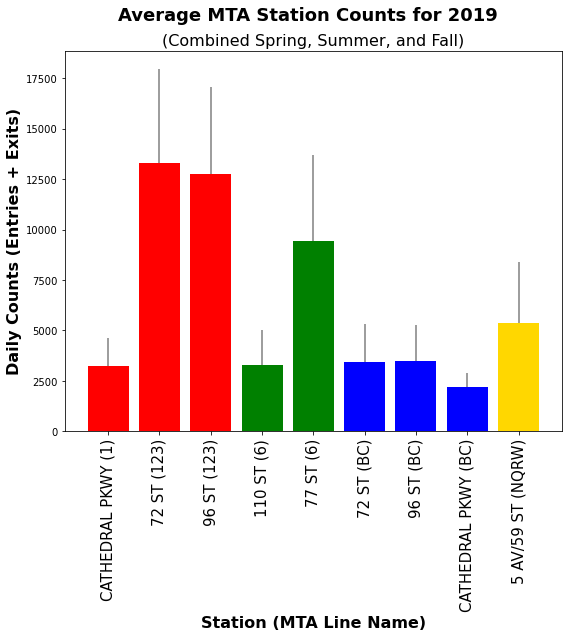

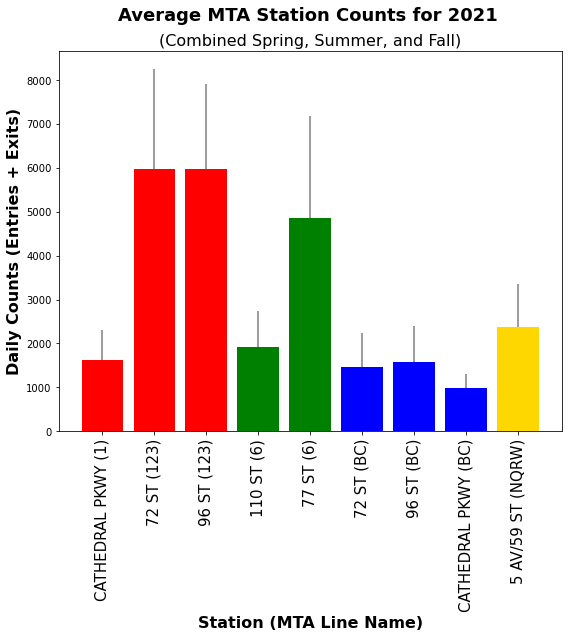

In [19]:
for yr in ["2019", "2021"]:
    mask_yr = f"YEAR == {yr}"
    temp_df = df_daily.query(mask_yr)
    
    # Find mean ± SD of total counts by station.
    station_mean_total = temp_df.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].mean().reset_index().sort_values("LINENAME")
    station_std_total = temp_df.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].std().reset_index().sort_values("LINENAME")

    #### Create the graphs.
    plt.figure(figsize=(8,9))
    
    x_ = station_mean_total["NAME"]
    y_ = station_mean_total["TOTAL_COUNTS"]
    
    # To plot only the top error bars, must include 0's.
    std_ = [[0] * len(station_std_total["TOTAL_COUNTS"]), station_std_total["TOTAL_COUNTS"]]

    x_axis = np.arange(len(x_))

    # Colors to use.
    c_ = ["red", "red", "red", "green", "green", "blue", "blue", "blue", "gold"]
    
    plt.bar(x_axis, y_, color=c_)
    plt.errorbar(x_axis, y_, std_, linestyle="None", color="C7")

    plt.xticks(x_axis, x_, rotation = 90, fontsize=15)
    plt.xlabel("Station (MTA Line Name)", fontweight="bold", fontsize=16)
    plt.ylabel("Daily Counts (Entries + Exits)", fontweight="bold", fontsize=16)
    plt.suptitle(f"Average MTA Station Counts for {yr}", fontweight="bold", fontsize=18, x=0.54)
    plt.title("(Combined Spring, Summer, and Fall)", fontsize=16)
    # plt.show()

    plt.tight_layout() 
    plt.savefig(f"EDA_summary_figure_{yr}.jpg");

### Daily totals across the seasons (all, weekdays, and weekends) by year (2019 and 2021)

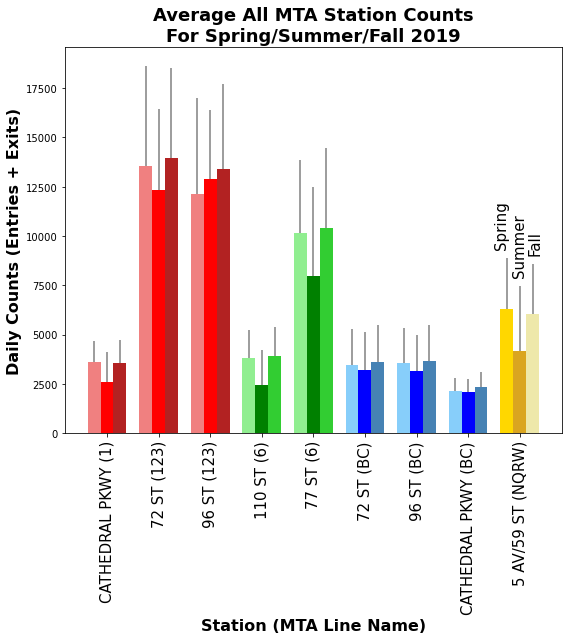

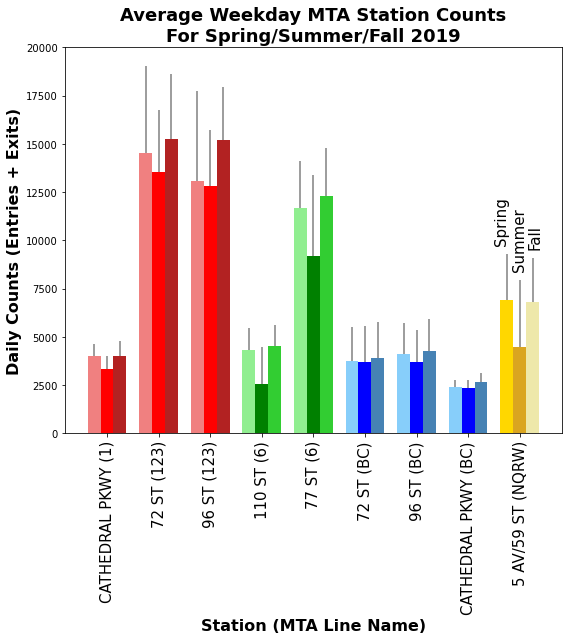

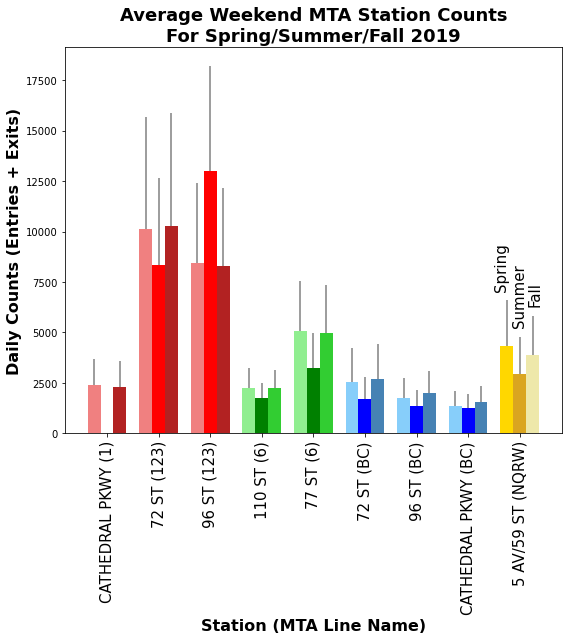

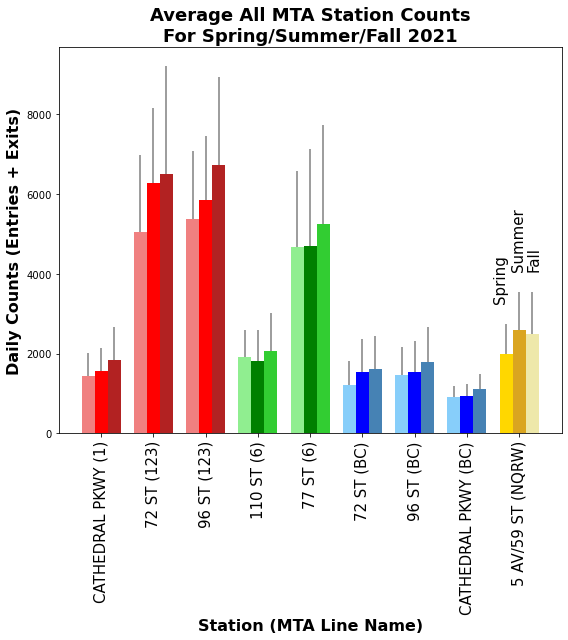

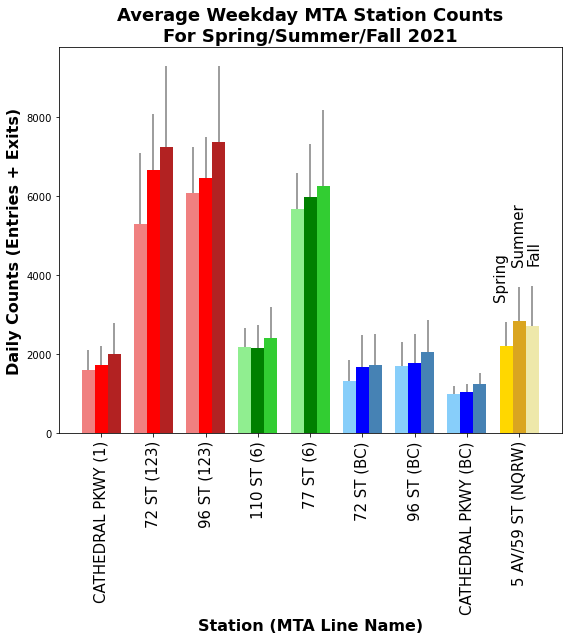

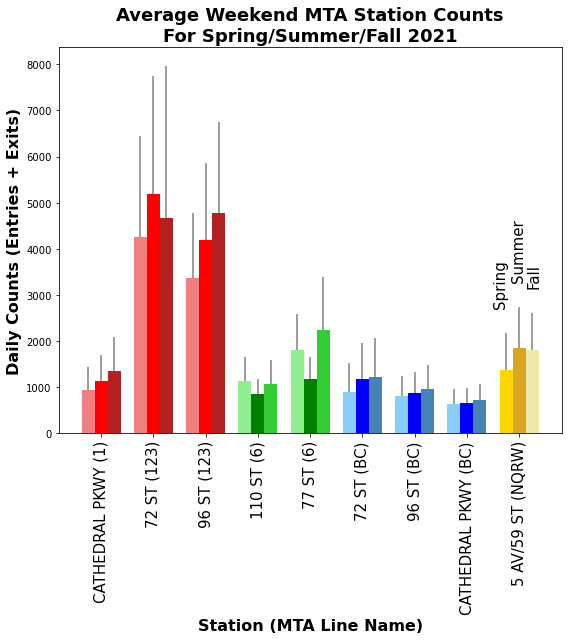

In [20]:
for yr in ["2019", "2021"]:
    for day_type in ["all", "weekday", "weekend"]:
        if day_type == "all":
            mask = f"YEAR == {yr}"
        else:
            mask = f"YEAR == {yr} & WEEKENDS == '{day_type}'"
        temp_df = df_daily.query(mask)
        
        # Create the needed datasets (first get seasons then get mean ± SD).
        df_spring = temp_df.query("SEASONS == 'spring'")
        df_summer = temp_df.query("SEASONS == 'summer'")
        df_fall = temp_df.query("SEASONS == 'fall'")

        station_mean_spring = df_spring.groupby(["NAME", "SEASONS", "LINENAME"])[["TOTAL_COUNTS"]].mean().reset_index().sort_values("LINENAME")
        station_std_spring = df_spring.groupby(["NAME", "SEASONS", "LINENAME"])[["TOTAL_COUNTS"]].std().reset_index().sort_values("LINENAME")
        station_mean_summer = df_summer.groupby(["NAME", "SEASONS", "LINENAME"])[["TOTAL_COUNTS"]].mean().reset_index().sort_values("LINENAME")
        station_std_summer = df_summer.groupby(["NAME", "SEASONS", "LINENAME"])[["TOTAL_COUNTS"]].std().reset_index().sort_values("LINENAME")
        station_mean_fall = df_fall.groupby(["NAME", "SEASONS", "LINENAME"])[["TOTAL_COUNTS"]].mean().reset_index().sort_values("LINENAME")
        station_std_fall = df_fall.groupby(["NAME", "SEASONS", "LINENAME"])[["TOTAL_COUNTS"]].std().reset_index().sort_values("LINENAME")

        # Create the graph.
        plt.figure(figsize=(8,9))

        x_ = station_mean_spring["NAME"]
        x_axis = np.arange(len(x_))

        y_spring = station_mean_spring["TOTAL_COUNTS"]
        y_summer = station_mean_summer["TOTAL_COUNTS"]
        y_fall = station_mean_fall["TOTAL_COUNTS"]

        # To plot only the top error bars, must include 0's.
        std_spring = [[0] * len(station_std_spring["TOTAL_COUNTS"]), station_std_spring["TOTAL_COUNTS"]]
        std_summer = [[0] * len(station_std_spring["TOTAL_COUNTS"]), station_std_summer["TOTAL_COUNTS"]]
        std_fall = [[0] * len(station_std_spring["TOTAL_COUNTS"]), station_std_fall["TOTAL_COUNTS"]]

        # Colors to use.
        c_spring = ["lightcoral", "lightcoral", "lightcoral", "lightgreen",
                    "lightgreen", "lightskyblue", "lightskyblue","lightskyblue","gold"]
        c_summer = ["red", "red", "red", "green", "green", "blue", "blue", "blue", "goldenrod"]
        c_fall = ["firebrick", "firebrick", "firebrick", "limegreen", "limegreen", "steelblue",
                  "steelblue", "steelblue", "palegoldenrod"]

        plt.bar(x_axis - 0.25, y_spring, width = 0.25, label = "Spring", color=c_spring)
        plt.errorbar(x_axis - 0.25, y_spring, std_spring, linestyle="None", color="C7", fillstyle="top")
        plt.bar(x_axis, y_summer, width = 0.25, label = "Summer", color=c_summer)
        plt.errorbar(x_axis, y_summer, std_summer, linestyle="None", color="C7")
        plt.bar(x_axis + 0.25, y_fall, width = 0.25, label = "Fall", color=c_fall)
        plt.errorbar(x_axis + 0.25, y_fall, std_fall, linestyle="None", color="C7")

        note_spring = (station_mean_spring.loc[1,"TOTAL_COUNTS"]) + (station_std_spring.loc[1,"TOTAL_COUNTS"]+600)
        note_summer = (station_mean_summer.loc[1,"TOTAL_COUNTS"]) + (station_std_summer.loc[1,"TOTAL_COUNTS"]+600)
        note_fall = (station_mean_fall.loc[1,"TOTAL_COUNTS"]) + (station_std_fall.loc[1,"TOTAL_COUNTS"]+600)

        plt.annotate("Spring", xy=(0,10),
                     xytext=(7.5,note_spring), rotation=90, fontsize=15)
        plt.annotate("Summer", xy=(0,10), 
                     xytext=(7.85,note_summer), rotation=90, fontsize=15)
        plt.annotate("Fall", xy=(0,10), 
                     xytext=(8.15,note_fall), rotation=90, fontsize=15)

        plt.xticks(x_axis, x_, rotation = 90, fontsize=15)
        plt.xlabel("Station (MTA Line Name)", fontweight="bold", fontsize=16)
        plt.ylabel("Daily Counts (Entries + Exits)", fontweight="bold", fontsize=16)
        plt.title(f"Average {day_type.capitalize()} MTA Station Counts\nFor Spring/Summer/Fall {yr}", 
          fontweight="bold", fontsize=18)

        plt.tight_layout() 

        plt.savefig(f"EDA_figure_{day_type}_{yr}.jpg");

### Daily totals comparing weekends vs weekdays (combined seasons) by year (2019 and 2021).

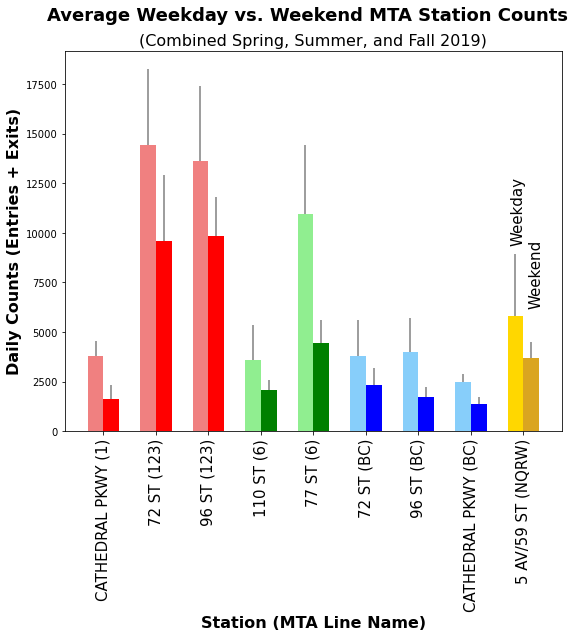

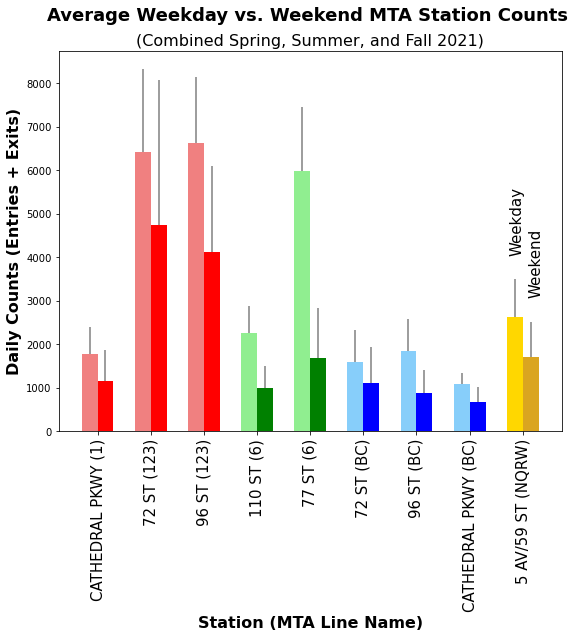

In [21]:
for yr in ["2019", "2021"]:
    mask = f"YEAR == {yr}"
    temp_df = df_daily.query(mask)
    
    # Create the summary data (first group by day type then get mean ± SD).
    df_weekday = temp_df.query("WEEKENDS == 'weekday'")
    df_weekend = temp_df.query("WEEKENDS == 'weekend'")

    station_mean_weekday = df_weekday.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].mean().reset_index().sort_values("LINENAME")
    station_std_weekday = df_weekday.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].std().reset_index().sort_values("LINENAME")
    station_mean_weekend = df_weekend.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].mean().reset_index().sort_values("LINENAME")
    station_std_weekend = df_weekend.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].std().reset_index().sort_values("LINENAME")

    # Create graphs.
    plt.figure(figsize=(8,9))

    x_ = station_mean_weekday["NAME"]
    x_axis = np.arange(len(x_))

    y_day = station_mean_weekday["TOTAL_COUNTS"]
    y_end = station_mean_weekend["TOTAL_COUNTS"]

    # To plot only the top error bars, must include 0's.
    std_day = [[0] * len(station_std_weekday["TOTAL_COUNTS"]), station_std_weekday["TOTAL_COUNTS"]]
    std_end = [[0] * len(station_std_weekend["TOTAL_COUNTS"]), station_std_weekend["TOTAL_COUNTS"]]


    c_day = ["lightcoral", "lightcoral", "lightcoral", "lightgreen", 
                "lightgreen", "lightskyblue", "lightskyblue","lightskyblue","gold"]
    c_end = ["red", "red", "red", "green", "green", "blue", "blue", "blue", "goldenrod"]
    
    plt.bar(x_axis - 0.15, y_day, width = 0.3, label = "Spring", color=c_day)
    plt.errorbar(x_axis - 0.15, y_day, std_day, linestyle="None", color="C7", fillstyle="top")
    plt.bar(x_axis + 0.15, y_end, width = 0.3, label = "Fall", color=c_end)
    plt.errorbar(x_axis + 0.15, y_end, std_fall, linestyle="None", color="C7")

    
    note_day = (station_mean_weekday.loc[1,"TOTAL_COUNTS"]) + (station_std_weekday.loc[1,"TOTAL_COUNTS"]+600)
    note_end = (station_mean_weekend.loc[1,"TOTAL_COUNTS"]) + (station_std_weekend.loc[1,"TOTAL_COUNTS"]+600)
    
    plt.annotate("Weekday", xy=(0,10), xytext=(7.75,note_day), rotation=90, fontsize=15)
    plt.annotate("Weekend", xy=(0,10), xytext=(8.1,note_end), rotation=90, fontsize=15)

    plt.xticks(x_axis, x_, rotation = 90, fontsize=15)
    plt.xlabel("Station (MTA Line Name)", fontweight="bold", fontsize=16)
    plt.ylabel("Daily Counts (Entries + Exits)", fontweight="bold", fontsize=16)
    plt.suptitle("Average Weekday vs. Weekend MTA Station Counts",
              fontweight="bold", fontsize=18, x=0.54)
    plt.title(f"(Combined Spring, Summer, and Fall {yr})", fontsize=16)


    plt.tight_layout() 
    plt.savefig(f"EDA_weekend_comparison_{yr}.jpg");

## Compare Years.

In [22]:
# Create the summary tables.

df_daily["DATE"] = pd.to_datetime(df_daily["DATE"])

df_daily_2019 = df_daily.query("20190101 < DATE < 20191231")
df_daily_2021 = df_daily.query("20210101 < DATE < 20211231")

station_mean_2019 = df_daily_2019.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].mean().reset_index().sort_values("LINENAME")
station_std_2019 = df_daily_2019.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].std().reset_index().sort_values("LINENAME")
station_mean_2021 = df_daily_2021.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].mean().reset_index().sort_values("LINENAME")
station_std_2021 = df_daily_2021.groupby(["NAME", "LINENAME"])[["TOTAL_COUNTS"]].std().reset_index().sort_values("LINENAME")


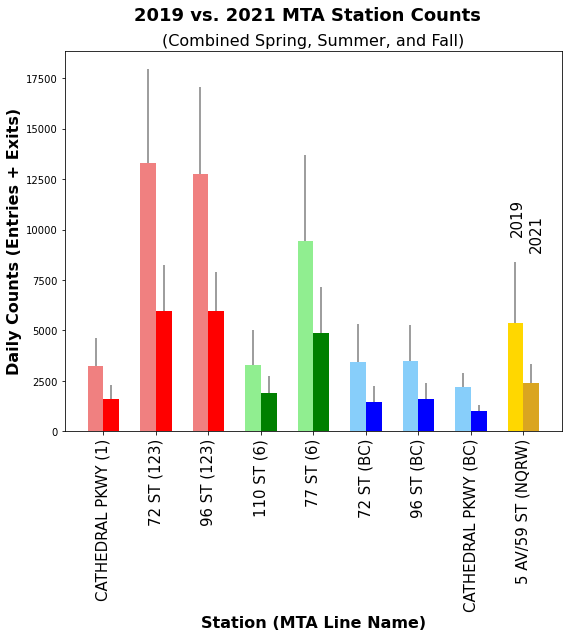

In [23]:
# Create the graph.

x = station_mean_2019["NAME"]

y_2019 = station_mean_2019["TOTAL_COUNTS"]
y_2020 = station_mean_2021["TOTAL_COUNTS"]

# To plot only the top error bars, must include 0's.
std_2019 = [[0] * len(station_std_2019["TOTAL_COUNTS"]), station_std_2019["TOTAL_COUNTS"]]
std_2020 = [[0] * len(station_std_2021["TOTAL_COUNTS"]), station_std_2021["TOTAL_COUNTS"]]

x_axis = np.arange(len(x))

c_day = ["lightcoral", "lightcoral", "lightcoral", "lightgreen", 
            "lightgreen", "lightskyblue", "lightskyblue","lightskyblue","gold"]
c_end = ["red", "red", "red", "green", "green", "blue", "blue", "blue", "goldenrod"]


# set the figure size.
plt.figure(figsize=(8,9))
# ensure that the x-axis doesn't get cut-off when saving.

plt.bar(x_axis - 0.15, y_2019, width = 0.3, label = "Spring", color=c_day)
plt.errorbar(x_axis - 0.15, y_2019, std_2019, linestyle="None", color="C7", fillstyle="top")
plt.bar(x_axis + 0.15, y_2020, width = 0.3, label = "Fall", color=c_end)
plt.errorbar(x_axis + 0.15, y_2020, std_2020, linestyle="None", color="C7")

plt.annotate("2019", xy=(0,10), xytext=(7.75,9800), rotation=90, fontsize=15)
plt.annotate("2021", xy=(0,10), xytext=(8.1,9000), rotation=90, fontsize=15)

plt.xticks(x_axis, x, rotation = 90, fontsize=15)
plt.xlabel("Station (MTA Line Name)", fontweight="bold", fontsize=16)
plt.ylabel("Daily Counts (Entries + Exits)", fontweight="bold", fontsize=16)
plt.suptitle("2019 vs. 2021 MTA Station Counts",
             fontweight="bold", fontsize=18, x=0.54)
plt.title("(Combined Spring, Summer, and Fall)", fontsize=16)

plt.tight_layout()
plt.savefig("EDA_figure_yr_comparison.jpg");

### Fluctuations across the day.

In [24]:
# Change time so that it's hours.

df_daily = df.groupby(["NAME", "SEASONS", "DATE", "WEEKENDS", "LINENAME", "TIME", "YEAR"])[["TOTAL_COUNTS"]].sum().reset_index()

df_daily["TIME_fixed"] = df_daily["TIME"].map(lambda x: int(x[:2]))

In [25]:
# Create a summary table (ONLY FOR 2021).

df_hourly = df_daily.groupby(["NAME", "LINENAME", "WEEKENDS", "TIME_fixed", "YEAR"])[["TOTAL_COUNTS"]].mean().reset_index()

df_hourly = df_hourly.query("YEAR == 2021")


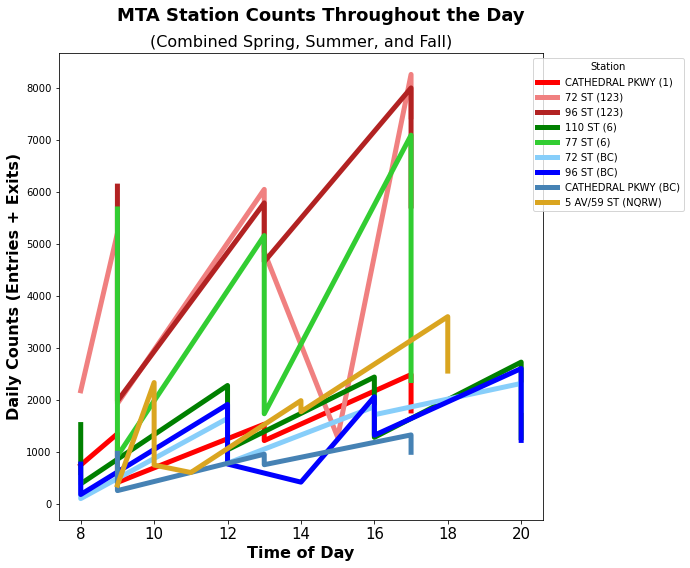

In [26]:
# Plot for all days combined.

df_hourly = df_hourly.sort_values(["LINENAME", "TIME_fixed"])

c_ = ["red", "lightcoral", "firebrick", "green", "limegreen", "lightskyblue", "blue", "steelblue", "goldenrod"]


plt.figure(figsize=(10,8))

for i,grp in enumerate(df_hourly["NAME"].unique()):
    mask = f"NAME == '{grp}'"
    temp_df = df_hourly.query(mask)
    
    plt.plot(temp_df["TIME_fixed"], temp_df["TOTAL_COUNTS"], color=c_[i], label=grp, linewidth=5)

plt.xticks(fontsize=15)
plt.xlabel("Time of Day", fontweight="bold", fontsize=16)
plt.ylabel("Daily Counts (Entries + Exits)", fontweight="bold", fontsize=16)
plt.suptitle("MTA Station Counts Throughout the Day",
             fontweight="bold", fontsize=18, x=0.45)
plt.title("(Combined Spring, Summer, and Fall)", fontsize=16)

plt.legend(bbox_to_anchor=(1.3, 1), loc="upper right", title="Station")

plt.tight_layout()
plt.savefig("EDA_figure_weekday_hourly.jpg");

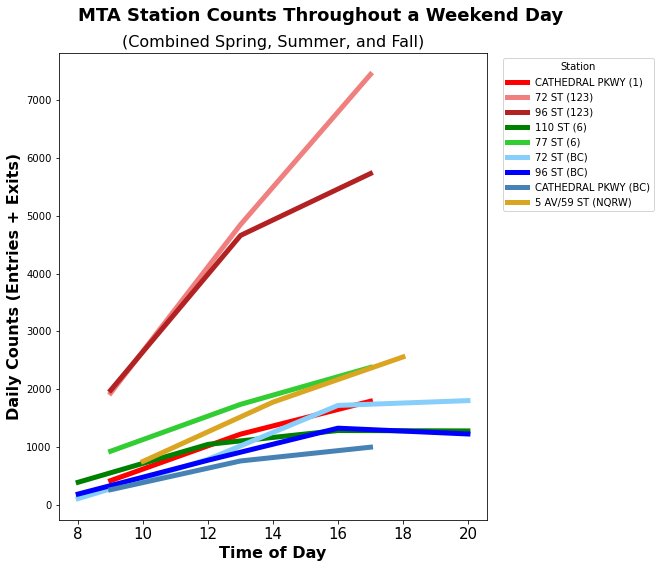

In [27]:
c_ = ["red", "lightcoral", "firebrick", "green", "limegreen", "lightskyblue", "blue", "steelblue", "goldenrod"]


plt.figure(figsize=(10,8))

for i,grp in enumerate(df_hourly["NAME"].unique()):
    mask = f"WEEKENDS == 'weekend' & NAME == '{grp}'"
    temp_df = df_hourly.query(mask)
    
    plt.plot(temp_df["TIME_fixed"], temp_df["TOTAL_COUNTS"], color=c_[i], label=grp, linewidth=5)

plt.xticks(fontsize=15)
plt.xlabel("Time of Day", fontweight="bold", fontsize=16)
plt.ylabel("Daily Counts (Entries + Exits)", fontweight="bold", fontsize=16)
plt.suptitle("MTA Station Counts Throughout a Weekend Day",
             fontweight="bold", fontsize=18, x=0.45)
plt.title("(Combined Spring, Summer, and Fall)", fontsize=16)
plt.legend(bbox_to_anchor=(1.4, 1), loc="upper right", title="Station")

plt.tight_layout()
plt.savefig("EDA_figure_weekend_hourly.jpg");